In [43]:
# @title Package Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import glob
from tqdm import tqdm
import os
from google.colab import files
from PIL import Image
import subprocess
import seaborn as sns
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

import torch.hub
!pip install timm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models
from torchsummary import summary

In [44]:
# @title Data Loading
print('Upload kaggle.json account information to download the dataset:')
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip -q brain-tumor-mri-dataset.zip

Upload kaggle.json account information to download the dataset:


Saving kaggle.json to kaggle.json
brain-tumor-mri-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Testing/glioma/Te-glTr_0000.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [45]:
DIR_TRAIN = '/content/Training/'
DIR_TEST = '/content/Testing/'

In [46]:
# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to a common size
    transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),  # Randomly flip the image vertically
    transforms.Grayscale(num_output_channels=3),  # Convert images to RGB format
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,)),  # Normalize the image pixel values
])

In [47]:
classes = os.listdir(DIR_TRAIN)
print("Total Classes: ", len(classes))

train_paths = []
train_labels = []
test_paths  = []
test_labels = []

for label in classes:
    for image in os.listdir(DIR_TRAIN+label):
        train_paths.append(DIR_TRAIN+label+'/'+image)
        train_labels.append(label)
    for image in os.listdir(DIR_TEST+label):
        test_paths.append(DIR_TEST+label+'/'+image)
        test_labels.append(label)

print("\nTotal train images: ", len(train_paths))
print("Total test images: ", len(test_paths))

Total Classes:  4

Total train images:  5712
Total test images:  1311


In [48]:
class Brain_Tumor_MRI_Dataset(Dataset):
    def __init__(self, image_paths, labels, classes, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.class_to_label = {class_name: i for i, class_name in enumerate(classes)}
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        label = self.class_to_label[self.labels[index]]

        image = Image.open(image_path)
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.image_paths)

In [49]:
train_dataset = Brain_Tumor_MRI_Dataset(train_paths, train_labels, classes, transform)
test_dataset = Brain_Tumor_MRI_Dataset(test_paths, test_labels, classes, transform)

In [50]:
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    num_workers = 2,
    shuffle = True,
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    num_workers = 2,
    shuffle = False,
)

In [51]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

Image size: torch.Size([3, 224, 224])
Label: 3


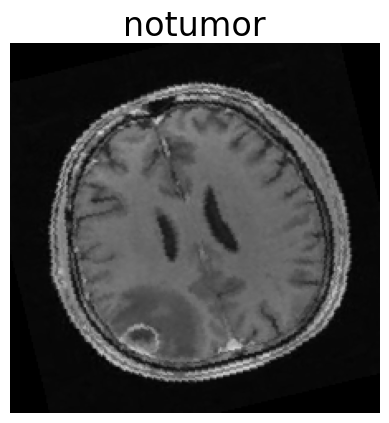

In [52]:
img, label = train_features_batch[0], train_labels_batch[0]
mean, std = 0.5, 0.5
img = std * img + mean
plt.imshow(img.permute(1, 2, 0), cmap='gray')
plt.title(classes[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}")

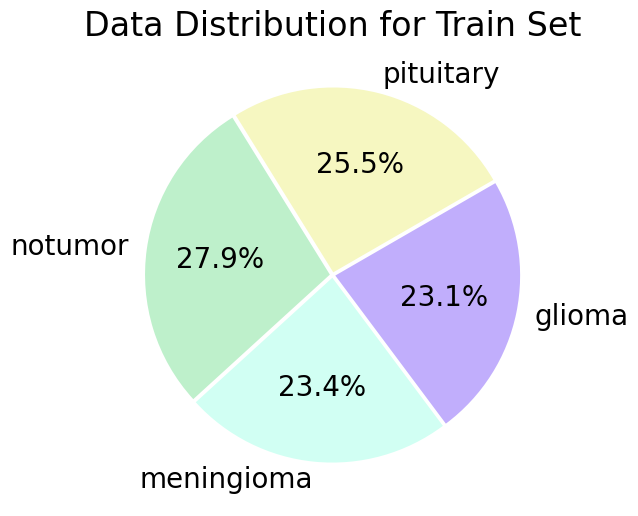

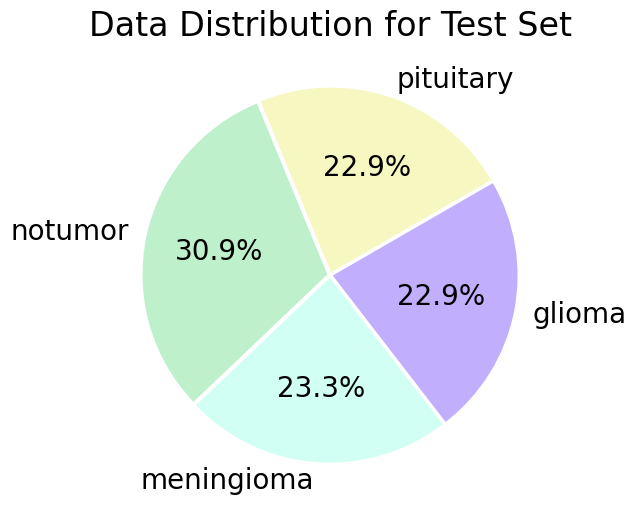

In [53]:
plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB', '#D1FFF3', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.title("Data Distribution for Train Set")
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015,0.015,0.015),
        startangle=30);

plt.figure(figsize=(14,6))
colors = ['#F6F7C1', '#BEF0CB', '#D1FFF3', '#C1AEFC']
plt.rcParams.update({'font.size': 20})
plt.title("Data Distribution for Test Set")
plt.pie([len([x for x in test_labels if x=='pituitary']),
         len([x for x in test_labels if x=='notumor']),
         len([x for x in test_labels if x=='meningioma']),
         len([x for x in test_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        colors=colors, autopct='%.1f%%', explode=(0.015,0.015,0.015,0.015),
        startangle=30);

In [54]:
def train_step(model,
               data_loader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device):

    # Send model to GPU
    model.to(device)
    train_loss, train_acc, counter = 0, 0, 0
    with tqdm(data_loader, desc ="  train") as train_tqdm:
        for X, y in train_tqdm:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            y_pred = model(X)

            # 2. Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss
            train_acc += accuracy_fn(true=y.cpu(),
                                     pred=y_pred.cpu())
            counter += 1
            train_tqdm.set_postfix(train_acc=train_acc/counter, train_loss=train_loss.item()/counter, refresh=True)

            # 3. Optimizer zero grad
            optimizer.zero_grad()

            # 4. Loss backward
            loss.backward()

            # 5. Optimizer step
            optimizer.step()

        # Calculate loss and accuracy per epoch and print out what's happening
        train_loss /= len(data_loader)
        train_acc /= len(data_loader)

    return train_loss.item(), train_acc

In [55]:
def test_step(model,
              data_loader,
              loss_fn,
              accuracy_fn,
              device):

    # Send model to GPU
    model.to(device)

    # put model in eval mode
    model.eval()
    test_loss, test_acc, counter = 0, 0, 0
    with torch.no_grad():
        with tqdm(data_loader, desc ="   test") as test_tqdm:
            for X, y in test_tqdm:
                # Send data to GPU
                X, y = X.to(device), y.to(device)

                # 1. Forward pass
                test_pred = model(X)

                # 2. Calculate loss and accuracy
                test_loss += loss_fn(test_pred, y)
                test_acc += accuracy_fn(true=y.cpu(),
                                        pred=test_pred.cpu())
                counter += 1
                test_tqdm.set_postfix(test_acc=test_acc/counter, test_loss=test_loss.item()/counter, refresh=True)

            # Adjust metrics and print out
            test_loss /= len(data_loader)
            test_acc  /= len(data_loader)

    return test_loss.item(), test_acc

In [56]:
def accuracy_fn(true, pred):
    pred = F.softmax(pred, dim = 1)
    true = torch.zeros(pred.shape[0], pred.shape[1]).scatter_(1, true.unsqueeze(1), 1.)
    acc = (true.argmax(-1) == pred.argmax(-1)).float().detach().numpy()
    acc = float((100 * acc.sum()) / len(acc))
    return round(acc, 5)

In [57]:
def optimizer(model):
  learning_rate = 0.0001
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  return optimizer

In [58]:
def fit(model, train_dataloader, test_dataloader, optimizer, epochs, lr_scheduler, loss_fn, device):
  train_epoch_loss = []
  train_epoch_accuracy = []
  test_epoch_loss = []
  test_epoch_accuracy = []

  train_time_start = timer()

  for epoch in range(epochs):
      print("EPOCH {}/{} :".format(epoch +1, epochs))
      train_loss, train_acc = train_step(data_loader=train_dataloader,
                                                model=model,
                                                loss_fn=loss_fn,
                                                optimizer=optimizer,
                                                accuracy_fn=accuracy_fn,
                                                device=device
                                                )
      test_loss, test_acc = test_step(data_loader=test_dataloader,
                                      model=model,
                                      loss_fn=loss_fn,
                                      accuracy_fn=accuracy_fn,
                                      device=device
                                      )

      train_epoch_loss.append(train_loss)
      train_epoch_accuracy.append(train_acc)
      test_epoch_loss.append(test_loss)
      test_epoch_accuracy.append(test_acc)

      # Update learning rate based on test accuracy
      lr_scheduler.step(test_acc)

  train_time_end = timer()
  total_time = train_time_end - train_time_start
  print(f"\n\nTrain time: {total_time:.5f} seconds")
  return train_epoch_loss, test_epoch_loss, train_epoch_accuracy, test_epoch_accuracy

In [59]:
def accloss_plots(train_loss, test_loss, train_acc, test_acc):

    num_epochs = len(train_loss)
    plt.figure(figsize=(13,5))
    plt.subplot(121)
    plt.plot(train_loss, 'r', label='Train')
    plt.plot(test_loss , 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Loss', fontsize=25, pad=15)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.subplot(122)
    plt.plot(train_acc, 'r', label='Train')
    plt.plot(test_acc, 'g', label='Test')
    plt.xlabel('Epochs', fontsize=10, labelpad=8)
    plt.title('Accuracy', fontsize=25, pad=15)
    plt.tight_layout(pad=3)
    plt.grid()
    plt.legend()
    sns.despine()
    plt.show();

In [60]:
# Define number of classes from each dataset
num_classes = len(classes)

# Define the Transformer model
transformer_model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)

transformer_model.head = nn.Sequential(
    nn.Flatten(),
    nn.Linear(transformer_model.head.in_features, 256),
    nn.ELU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(256, num_classes)
)

# Unfreeze the 12th Transformer Block
for param in transformer_model.blocks[11].parameters():
    param.requires_grad = True

# Unfreeze the 11th Transformer Block
for param in transformer_model.blocks[10].parameters():
    param.requires_grad = True

transformer_model

Using cache found in /root/.cache/torch/hub/facebookresearch_deit_main


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [61]:
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

optimizer = optimizer(transformer_model)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.6, patience=3,
                                 threshold=0.001, threshold_mode='rel', cooldown=0, min_lr=0.0000001, verbose=True)

In [63]:
epochs_num = 10
train_loss1, test_loss1, train_acc1, test_acc1 = fit(
    transformer_model, train_dataloader, test_dataloader, optimizer, epochs_num, lr_scheduler, loss_fn, device)

EPOCH 1/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.70it/s, test_acc=95.7, test_loss=0.121]


EPOCH 2/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.72it/s, test_acc=97, test_loss=0.0976]


EPOCH 3/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.68it/s, test_acc=96.6, test_loss=0.0893]


EPOCH 4/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.73it/s, test_acc=98.2, test_loss=0.0517]


EPOCH 5/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.72it/s, test_acc=98.3, test_loss=0.0531]


EPOCH 6/10 :


   test: 100%|██████████| 41/41 [00:15<00:00,  2.64it/s, test_acc=98.7, test_loss=0.0479]


EPOCH 7/10 :


  train:  89%|████████▉ | 160/179 [02:47<00:19,  1.04s/it, train_acc=98.8, train_loss=0.0367]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
if w.is_alive():  File "/usr/local/lib/python3.10/dist-pac

EPOCH 8/10 :


  train:  82%|████████▏ | 146/179 [02:32<00:34,  1.05s/it, train_acc=98.7, train_loss=0.0406]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/util

EPOCH 9/10 :


  train:  74%|███████▍  | 133/179 [02:19<00:48,  1.05s/it, train_acc=98.8, train_loss=0.0315]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/util

EPOCH 10/10 :


  train:  18%|█▊        | 32/179 [00:33<02:34,  1.05s/it, train_acc=99.3, train_loss=0.0157]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7994f5468040>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils



Train time: 2029.09418 seconds


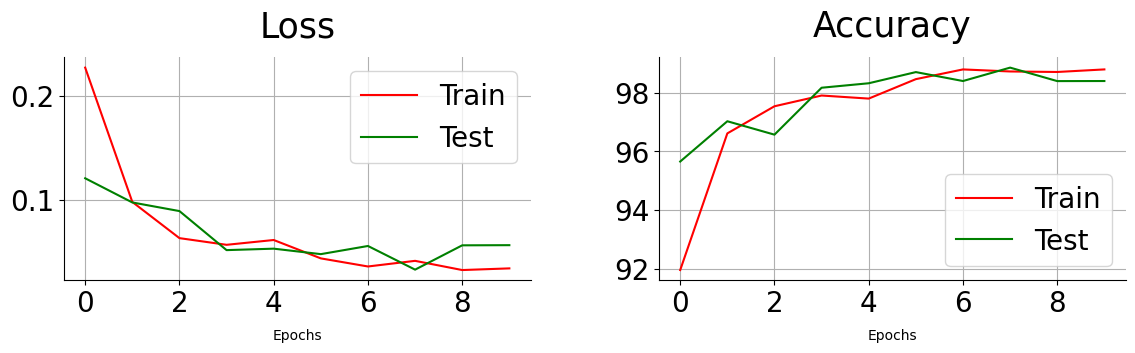

In [64]:
accloss_plots(train_loss=train_loss1,
                  test_loss=test_loss1,
                  train_acc=train_acc1,
                  test_acc=test_acc1)